# Algorithmic Methods of Data Mining - Homework 4


In [4]:
import matplotlib.pyplot as plt
import matplotlib.lines as lines
from Ex1_lib import *

# 1. Implementing your own Shazam

Shazam is a great application that can tell you the title of a song by listening to a short sample. The first task we had to solve was to implemtent a simple version of it, in particular, implementing a LSH algorithm that takes as input an audio track and finds relevant matches.

The [training set](https://www.kaggle.com/dhrumil140396/mp3s32k) 
was downloaded from Kaggle.

The following links were the queries:

- [query1](https://sapienza2021adm.s3.eu-south-1.amazonaws.com/hw4/queries/track1.wav)
- [query2](https://sapienza2021adm.s3.eu-south-1.amazonaws.com/hw4/queries/track2.wav)
- [query3](https://sapienza2021adm.s3.eu-south-1.amazonaws.com/hw4/queries/track3.wav)
- [query4](https://sapienza2021adm.s3.eu-south-1.amazonaws.com/hw4/queries/track4.wav)
- [query5](https://sapienza2021adm.s3.eu-south-1.amazonaws.com/hw4/queries/track5.wav)
- [query6](https://sapienza2021adm.s3.eu-south-1.amazonaws.com/hw4/queries/track6.wav)
- [query7](https://sapienza2021adm.s3.eu-south-1.amazonaws.com/hw4/queries/track7.wav)
- [query8](https://sapienza2021adm.s3.eu-south-1.amazonaws.com/hw4/queries/track8.wav)
- [query9](https://sapienza2021adm.s3.eu-south-1.amazonaws.com/hw4/queries/track9.wav)
- [query10](https://sapienza2021adm.s3.eu-south-1.amazonaws.com/hw4/queries/track10.wav)

## 1.2 Fingerprint hashing

The first step is convert the audio tracks of the dataset in a .wav file extension and than convert the data in order to work with some type of features.

There are multiple ways to do achieve our goal. In particular in this homework we tried to do it in 3 ways but at the end we used just 2 of it:

1. From the .wav files get just the frequency peacks of the songs and use them as features.
2. From the .wav files get the frequency and the time of each peak and then create a fingerprint with all the peaks of a time interval.
3. Use the peaks array that contain the indices of the frequency array and time array where the peak occured.


> The first option can give us a good representation of each song but with a very uge dataset can be not so representative of each song.
>
>The second option is the best way to have a good fingerprint of the songs: taking into account more than a single peak’s values create a fingerprints that have more entropy and therefore contain more information. Thus they are more powerful identifiers of songs since they will collide less but more peaks also means less robust in the face of noise.
>
>The last option is the less representative of a song cause it will take into account just the time of every peak.


At the end we used the first and the third option. We made this choice because the songs in the dataset have very few frequencies in common and to get a better feedback from the LSH we preferred to use some features that could collide. Despite this, the possibility of collision with only the frequencies remains very low and therefore we also used the peak indices to show a case with high collision probabilities.

>To convert the `.mp3` files in a `.wav` we used the function in the `audioSignal_functions.py` file

> To get the peaks frequencies  we create a function called `make_fingerprints()`. This function take as input a Path object to the song, a duration that rappresent the second of that song that will be sampled, and a hop. The hop parameter is used to create the fingerprints of the option 2 but we realize that those tipe of fingerprints were a too strong representations of the songs.

>To get the peaks indices we create a function called `getPeaks()`. This function take as input a Path object to the song and a duration that rappresent the second of that song that will be sampled.

> Last but not least, we make to functions (`make_all_fingerprints()` and `get_all_peaks()`) that run the respective functions for all the songs in the database. We parallelize this process for the sake of speed.

Now that we have out features we can apply out minHash algorithm. We code it using a class object called `MIN-HASH`. The minhash is a technique for quickly estimating how similar two sets are. The goal of the MinHash is to replace a large set with a smaller "signature" that still preserves the underlying similarity metric. It is based on the fact that the probability as minhased set is the same of another minashed set that is equal to the jaccard similarity of the two set. In formula:

\begin{equation}
Pr(\ h( \ A \ ) \ ) = Pr( \ h( \ B \ ) \ ) = jaccard( \ A, \ B \ )
\end{equation}

Where h is the minhash of the set.

> We used a class in order to keep all togheter some information like the minhash itself, the name of the song and the random permutations. Random permutations? What are you talking about?. Well, the common way to create a minhash algorithm is to create a signature matrix with all the data of the dataset just shuffling the rows of the fingerprints of all the songs all togheters. This is quite expensive if you have a lot of data to shuffle. Another way is to use hash, Why? What are hash functions doing? Simplifying — they map string to a number, so basically the same as the permutation! How is that better? We don’t need the whole dictionary before.
>
>So to actually implement that we need a number of hash function equal to the number of permutation that we want ot do... a lot of hash functions... But there is a solution. An Universal hashing family [(more info in this link)](https://www.cs.vu.nl/~tcs/ds/lecture6.pdf) .
>
\begin{equation}
h(k) = ( \ ( \ a · k + b \ ) \ \ \ mod \ p \  ) \ \ \ mod \ N
\end{equation}
>
>
> Now we have to chose a good value for p and N. We considered that the biggest value that an integer can assume is:  $ 2^{63}-1 $
> We descover that a good prime number for this time of calculations $(x \ mod \ p)$ is a [mersenne prime number](https://it.wikipedia.org/wiki/Numero_primo_di_Mersenne).
> In particular as we saw in this [paper](https://thomasahle.com/papers/mersenne.pdf):
>
>*In terms of speed, the main bottleneck in the above approach is the $mod$ operations. If we assume $r = 2$, the $mod \ \ r$ operation above can be replaced by a binary and $(\&)$: $x \ \ mod \ \ r = x \ \& \ r - 1$. Similarly, Carter and Wegman CW79 used a Mersenne prime $p = 2^{b} − 1$ to speed up the computation of the $(mod \ \ p)$ operations [...] allowing us to use the very fast bit-wise and $(\&)$ and the right-shift $(>>)$, instead of the expensive modulo operation.*
>
>The nearest mersen prime to the int max value of python is the M61 ($2^{61} -1$). Now we have to chose a value of $N$. We have $p > N$ by definition so a good choise will be another mersenne prime, the M31 that is equal to the max int value of the 32 bit enviroment ([see this page](https://note.nkmk.me/en/python-int-max-value/)).
>
>Now we random (uniform distribution) generate a number of $a$ and $b$ equal to the number of permutation we need. We generate $a$ and $b$ in order that all the possible int values can appear (more or less) so from 1 to M61 for $a$ and 0 to M61 for $b$. (the minimum value for a and b are like this by definition)
>
> The permutations (aka all the values of $a$ and $b$ are generated using the static method `_permutations(self, num_perm)`) and the formula is applied in the `gen_MinHash(self, vec, label)` static method. Now the trick to not permute all the song at the same time is to add a seed on out minhash object. In this way we permute all the song in the same method without to it with all the song at the same time.
>We code also a jaccard method to compute the jaccard similarity with different MIN-HASH object.

```python
    def _permutations(self, num_perm):
        gen = np.random.RandomState(self.seed)
        a_b = []
        for _ in range(num_perm):
            a_b.append((gen.randint(1, self._mersenne61, dtype="int64"), gen.randint(0, self._mersenne61, dtype="int64")))
            
        return np.array(a_b, dtype="int64").T


    def gen_MinHash(self, vec, label):
        self.label = label
        hashed_values = np.array([self.hashfunc(el) for el in vec], dtype="int64")
        a, b = self.permutations
        min_hashed_values = []
        for i, j in zip(a,b):
            min_hashed_values.append((((hashed_values * i)+j)%self._mersenne61))

        phv = np.bitwise_and(np.array(min_hashed_values), self._max_hash).T

        self.hashvalues = phv.min(axis=0)

    def jaccard(self, other):
        return float(np.count_nonzero(self.hashvalues==other.hashvalues)) / float(len(self))
```



The last part to code is the LSH. We code it in a class called `LSH`. LSH can be considered an algorithm for dimensionality reduction. If we want to query the dataset with our unknown song we should check the similarity of every song in the dataset and this may take too much. The LSH need to avoid this just selecting the most probable song that could match with the query so, instead of compute the jaccard of every song in our dataset, we will compute the jaccard with just a subset of it.

> Our `LSH` contain a list of `HashTable` class object that rappresent the bands. The scope is to split a minhash in bands so every band will have a different hashTable. Let's take as example a band size of 2. In this way we will end up with two hash tables, containing as key the hash of the minhashes in that band and as value a list of song name. The value is a list because considering just a band of the all minash will increase the probability of collisions between different minhashes and that is exactly what we want.

![LSH image](img/lsh.png)

> to add a minhash to the `LSH` object we code the `addMinHash(self, minhash)` static method that add the name of the song in the dictionary of names and create the bands, filling the `HashTable`, with the `_create_store_band(self, minhash)`.

```python
def addMinHash(self, minhash):
        self.minhash_dict[minhash.label] = minhash
        self._create_store_band(minhash.hashvalues, minhash.label)
            
    def _create_store_band(self, vec, label):
        
        row_per_band = self.minhash_len // self.num_band
        
        subVec = []
        
        for i in range(0,self.minhash_len, row_per_band):
            subVec.append(vec[i:i+row_per_band])
        

        for band, table in zip(subVec, self.hash_tables):
            table.setitem(band, label)
```

> To query the `LSH` class we implement the `query_lsh(self, minhash_query)` static method that search in every `HashTable` if the relative band of the query match. Then it add all the songs name that it found in a list and compute the jaccard similarity of all the candidate songs with the query.

```python
def query_lsh(self, minhash_query):
        subVec_query = self._create_band(minhash_query.hashvalues)
        match = set()
        similarities = []
        for table, band in zip(self.hash_tables, subVec_query):
            
            key = 0
            for i in band:
                key ^= fibonacci_hash_float(i) ^ key
                
            if(table.hash_table.get(key, "NA") != "NA"):
                match.update(tuple(table.hash_table.get(key)))
                
        for m in match:
            
            similarities.append((self.minhash_dict[m].jaccard(minhash_query), m.name))
            
            similarities = [ i for i in sorted(similarities, reverse=True)]
                
        return similarities
```

> Last but not least we implement a function named `query(bands, minhashes, query_minhashes, num_perm)` to create the `LSH` object with all the minhashes of the database and query it with a song.

```python
def query(bands, minhashes, query_minhashes, num_perm = 128):
    
    for b in bands:
        out = []
        lsh = LSH(minhash_len=num_perm, num_band=b)
        print("==========================\nQuery with " + str(b) + " number of bands:\n")
        for i in minhashes:
            lsh.addMinHash(i)

        for query in query_minhashes:
            dfout = pd.DataFrame()
            dfout[query.label.name] = [name[1] for name in lsh.query_lsh(query) if len(name) > 0]
            dfout["similarity"] = [sim[0] for sim in lsh.query_lsh(query) if len(sim) > 0]
     
            dfout.set_index("similarity", inplace=True)
            if(len(dfout) > 0):
                display(dfout)
                print("\n\n")

```

Now that we have all the tools we need we can search the name of the query song, but first we need to define a threshold. As described here, a good approsimation of the threshold is $(1/b)^{1/r}$ where b is the number of bands and r is the number of rows in the band.

> We implement two function to get a good threshold named `threshold(b, num_perm)` and `find_band_from_threshold(th, num_perm)`.
>
>The firts just compute the threshold once we had a number of bands. To decide a good number of bend we used the second functions that generate a list of all possible number of band given a permutation number (aka the lenght of our minhash) and compute the threshold of every band. Than it search the nearest value of the desired threshold.


```python

def threshold(b, num_perm = 128):
    
    r = num_perm / b
    t = 1 - ((1/b)**(1/r))
    
        
    return t


def find_band_from_threshold(th, num_perm = 128):
    bands = np.array(range(1,num_perm+1))
    all_thresholds = threshold(bands)
    
    err = []
    for b, t in zip(bands,all_thresholds):
        if(128 % b == 0):
            err.append((abs(t-th), b))
    
    opt_band = min(err)[1]
    
    final_threshold = all_thresholds[opt_band-1]
    
    return opt_band, bands, all_thresholds, final_threshold

```






\begin{equation}
\
\end{equation}

\begin{equation}
\
\end{equation}

\begin{equation}
\
\end{equation}

\begin{equation}
\
\end{equation}




## Query the database

>We choose five type of threshold: 0.1, 0.35, 0.5, 0.8, 1.
>
>Let's compute the nearest threshold and plot them:

 Number of bands: [8, 16, 32, 64, 128]


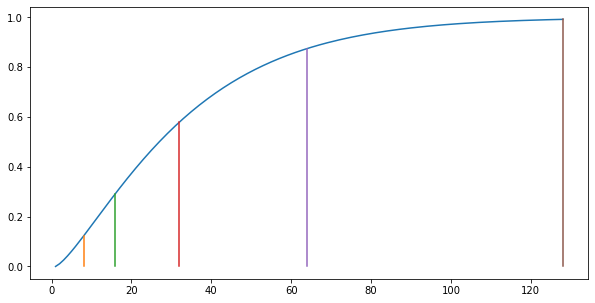

In [8]:
b1, bands, thresholds, final_th1 = find_band_from_threshold(0.1)
b2, _, _, final_th2 = find_band_from_threshold(0.35)
b3, _, _, final_th3 = find_band_from_threshold(0.5)
b4, _, _, final_th4 = find_band_from_threshold(0.80)
b5, _, _, final_th5 = find_band_from_threshold(1)

plt.figure(figsize=(10,5))
plt.plot(bands, thresholds);
plt.plot([b1,b1],[0, final_th1]);
plt.plot([b2,b2],[0, final_th2]);
plt.plot([b3,b3],[0, final_th3]);
plt.plot([b4,b4],[0, final_th4]);
plt.plot([b5,b5],[0, final_th5]);

bands_128 = [b1,b2,b3,b4,b5]
print(f" Number of bands: {bands_128}")

>Now that we have choose the number of band we can start to query the dataset. In the first query we used the peaks indices as features. How we can see in the output, every song have a lot of possible matches with the query and the number increase with the number of band we choose, due to the fact that the features we have choose are weak identifiers of the songs.

In [ ]:
#shinlges = get_all_peaks(duration=30, songs=songs)
#save_object(shinlges, "./data/fingerprints/peaks_frequences/fings_dur_30_hop_0.plk")
shinlges = read_object("./data/fingerprints/peaks_indices/peaks_dur_30_hop_0.plk")
minhashes = []

for fing, song in shinlges:
    m = MIN_HASH(num_perm=128, vec=fing, label=song)
    minhashes.append(m)

shinlgesq = get_all_peaks(duration=5, songs=queries)
save_object(shinlgesq, "./data/fingerprints/peaks_indices/peaksq_dur_5_hop_0.plk")
#shinlgesq = read_object("./data/fingerprints/peaks_indices/peaksq_dur_5_hop_0.plk)
minhashesq = []

for fing, song in shinlgesq:
    m = MIN_HASH(num_perm=128, vec=fing, label=song)
    minhashesq.append(m)

In [11]:
query(bands_128, minhashes, minhashesq)

Query with 8 number of bands:



,track10.wav
similarity,
0.062500,12-Breathing_in_fumes.wav
0.062500,06-Nobody_s_Fault.wav
0.046875,15-Bicycle_Race_1991_Remix_.wav
0.039062,08-I_Wanna_Melt_With_U.wav
0.039062,02-Brat.wav
0.031250,11-1000_Oceans.wav
0.031250,10-Like_Spinning_Plates.wav
0.031250,08-The_Red_Strokes.wav
0.031250,05-Night_Vision.wav


,track9.wav
similarity,
0.039062,06-Nobody_s_Fault.wav
0.031250,09-Words_Of_Love.wav
0.031250,09-Sweet_Baby.wav
0.031250,06-Vulnerable.wav
0.031250,05-Who_s_Gonna_Ride_Your_Wild_Horses.wav
0.031250,03-A_question_of_lust.wav
0.023438,10-The_Wanderer.wav
0.023438,10-Mr_Blue.wav
0.023438,06-Dancing_Nancies.wav


,track4.wav
similarity,
0.171875,04-Ob-La-Di_Ob-La-Da.wav
0.085938,05-Machines_Back_To_Humans_.wav
0.062500,10-No_Surprises.wav
0.062500,02-Bad_Sneakers.wav
0.054688,10-Hats_Off_To_Roy_Harper.wav
...,...
0.007812,03-Bells_For_Her.wav
0.007812,02-Before_You_Accuse_Me.wav
0.007812,01-Skies_the_Limit.wav


,track6.wav
similarity,
0.125000,05-Heartbreaker.wav
0.070312,01-Where_the_Streets_Have_No_Name.wav
0.054688,10-The_Top.wav
0.054688,06-Sweet_Emotion.wav
0.054688,04-Let_s_Pretend_We_re_Married.wav
...,...
0.007812,04-Glory_Of_The_80_s.wav
0.007812,03-The_Power_of_Orange_Knickers.wav
0.007812,03-I_m_In_Love_With_My_Car.wav


,track3.wav
similarity,
0.210938,07-October.wav
0.039062,13-I_m_In_Love_With_My_Car.wav
0.039062,04-Every_Now_And_Then.wav
0.039062,01-Black_Celebration.wav
0.031250,11-Ireland.wav
0.031250,08-Shanti-Ashtangi.wav
0.031250,06-Thin_Man.wav
0.031250,05-_Anesthesia_Pulling_Teeth.wav
0.031250,04-The_Ballad_Of_Dorothy_Parker.wav


,track2.wav
similarity,
0.140625,06-I_Want_To_Break_Free.wav
0.070312,08-Cowboy_Bill.wav
0.062500,08-King_Of_The_World.wav
0.062500,03-The_Last_Stop.wav
0.054688,10-All_The_Critics_Love_U_In_New_York.wav
...,...
0.007812,01-Tom_s_Diner.wav
0.007812,01-The_Look.wav
0.007812,01-Rock_In_This_Pocket_Song_Of_David_.wav


,track5.wav
similarity,
0.132812,06-Karma_Police.wav
0.039062,12-Love_Is_Blindness.wav
0.039062,01-Love_in_Store.wav
0.023438,12-Everyday.wav
0.023438,08-The_Red_Strokes.wav
0.023438,08-Because.wav
0.023438,02-Commotion.wav
0.015625,07-Venus_de_Milo.wav
0.015625,06-Sleeps_With_Butterflies.wav


,track7.wav
similarity,
0.078125,12-You_Can_t_Do_That.wav
0.078125,10-Effigy.wav
0.062500,15-Strangeland.wav
0.062500,08-Red_Light.wav
0.062500,07-Blue_Light.wav
0.054688,07-The_Hand_That_Feeds.wav
0.046875,11-Monkey_in_Your_Soul.wav
0.046875,06-Only_over_You.wav
0.039062,11-Stolen_Away_On_55th_3rd.wav


,track8.wav
similarity,
0.242188,01-American_Idiot.wav
0.093750,13-She_Came_In_Through_The_Bathroom_Window.wav
0.093750,02-Babe_I_m_Gonna_Leave_You.wav
0.085938,01-Erotica.wav
0.078125,04-Thank_You.wav
...,...
0.007812,01-Tom_s_Diner.wav
0.007812,01-Rock_In_This_Pocket_Song_Of_David_.wav
0.007812,01-Rikki_Don_t_Lose_That_Number.wav


,track1.wav
similarity,
0.218750,03-Dream_On.wav
0.070312,08-Trip_Through_Your_Wires.wav
0.070312,07-Keep_Passing_The_Open_Windows.wav
0.070312,06-Automatic.wav
0.062500,34-_34.wav
...,...
0.007812,03-Sheer_Heart_Attack.wav
0.007812,03-Don_t_Take_Me_Alive.wav
0.007812,03-Bells_For_Her.wav





Query with 16 number of bands:



,track10.wav
similarity,
0.109375,01-Black_Friday.wav
0.078125,14-The_Beekeeper.wav
0.062500,12-Breathing_in_fumes.wav
0.062500,06-Nobody_s_Fault.wav
0.054688,07-watercolours_in_the_rain.wav
...,...
0.007812,02-Rodeo.wav
0.007812,02-Old_Dirt_Hill_Bring_That_Beat_Back_.wav
0.007812,02-Dreams.wav


,track9.wav
similarity,
0.039062,06-Nobody_s_Fault.wav
0.031250,09-Words_Of_Love.wav
0.031250,09-Sweet_Baby.wav
0.031250,06-Vulnerable.wav
0.031250,05-Who_s_Gonna_Ride_Your_Wild_Horses.wav
0.031250,03-A_question_of_lust.wav
0.023438,10-The_Wanderer.wav
0.023438,10-Mr_Blue.wav
0.023438,06-Dancing_Nancies.wav


,track4.wav
similarity,
0.171875,04-Ob-La-Di_Ob-La-Da.wav
0.085938,08-Trip_Through_Your_Wires.wav
0.085938,05-Machines_Back_To_Humans_.wav
0.070312,01-Draw_the_Line.wav
0.062500,10-No_Surprises.wav
...,...
0.007812,02-Before_You_Accuse_Me.wav
0.007812,01-Skies_the_Limit.wav
0.007812,01-Rikki_Don_t_Lose_That_Number.wav


,track6.wav
similarity,
0.125000,05-Heartbreaker.wav
0.070312,01-Where_the_Streets_Have_No_Name.wav
0.054688,10-The_Top.wav
0.054688,06-Sweet_Emotion.wav
0.054688,04-Let_s_Pretend_We_re_Married.wav
...,...
0.007812,03-The_Power_of_Orange_Knickers.wav
0.007812,03-The_Boston_Rag.wav
0.007812,03-I_m_In_Love_With_My_Car.wav


,track3.wav
similarity,
0.210938,07-October.wav
0.054688,06-The_Change.wav
0.046875,02-Even_Better_Than_The_Real_Thing.wav
0.039062,13-I_m_In_Love_With_My_Car.wav
0.039062,12-Little_Star.wav
...,...
0.007812,03-The_Power_of_Orange_Knickers.wav
0.007812,03-Bye_Bye_Baby.wav
0.007812,02-Widow_s_Walk.wav


,track2.wav
similarity,
0.140625,06-I_Want_To_Break_Free.wav
0.070312,08-Cowboy_Bill.wav
0.070312,05-Go_to_Sleep.wav
0.062500,08-King_Of_The_World.wav
0.062500,03-The_Last_Stop.wav
...,...
0.007812,01-Rock_In_This_Pocket_Song_Of_David_.wav
0.007812,01-Rikki_Don_t_Lose_That_Number.wav
0.007812,01-My_Name_Is_Prince.wav


,track5.wav
similarity,
0.132812,06-Karma_Police.wav
0.070312,13-Ireland.wav
0.070312,03-Over_The_Hills_And_Far_Away.wav
0.062500,07-I_would_die_4_u.wav
0.062500,05-Go_Your_Own_Way.wav
0.054688,09-Bad_Wisdom.wav
0.054688,03-Everywhere.wav
0.046875,11-Acrobat.wav
0.046875,10-Neighborhood_Girls.wav


,track7.wav
similarity,
0.250000,05-Go_Your_Own_Way.wav
0.078125,12-You_Can_t_Do_That.wav
0.078125,10-Effigy.wav
0.070312,07-I_would_die_4_u.wav
0.062500,15-Strangeland.wav
...,...
0.015625,06-Songbird.wav
0.015625,06-How_Beautiful_You_Are.wav
0.015625,02-Night_by_Night.wav


,track8.wav
similarity,
0.242188,01-American_Idiot.wav
0.093750,13-She_Came_In_Through_The_Bathroom_Window.wav
0.093750,02-Babe_I_m_Gonna_Leave_You.wav
0.085938,01-Erotica.wav
0.078125,04-Thank_You.wav
...,...
0.007812,01-Tom_s_Diner.wav
0.007812,01-Rock_In_This_Pocket_Song_Of_David_.wav
0.007812,01-Rikki_Don_t_Lose_That_Number.wav


,track1.wav
similarity,
0.218750,03-Dream_On.wav
0.093750,08-Happiness_Is_A_Warm_Gun.wav
0.078125,08-Behind_the_Mask.wav
0.078125,06-Yellow_Submarine.wav
0.070312,13-Rocky_Raccoon.wav
...,...
0.007812,02-Impressive_Instant.wav
0.007812,02-Even_Better_Than_The_Real_Thing.wav
0.007812,02-Bird_Mad_Girl.wav





Query with 32 number of bands:



,track10.wav
similarity,
0.109375,01-Black_Friday.wav
0.093750,12-Everyday.wav
0.078125,14-The_Beekeeper.wav
0.078125,10-Sun_King.wav
0.062500,12-Breathing_in_fumes.wav
...,...
0.007812,02-Dreams.wav
0.007812,02-Bad_Sneakers.wav
0.007812,01-In_Between_Days.wav


,track9.wav
similarity,
0.039062,06-Nobody_s_Fault.wav
0.031250,09-Words_Of_Love.wav
0.031250,09-Sweet_Baby.wav
0.031250,06-Vulnerable.wav
0.031250,05-Who_s_Gonna_Ride_Your_Wild_Horses.wav
0.031250,03-A_question_of_lust.wav
0.023438,10-The_Wanderer.wav
0.023438,10-Mr_Blue.wav
0.023438,06-Dancing_Nancies.wav


,track4.wav
similarity,
0.171875,04-Ob-La-Di_Ob-La-Da.wav
0.085938,08-Trip_Through_Your_Wires.wav
0.085938,05-Machines_Back_To_Humans_.wav
0.070312,12-Shadow_Of_A_Doubt.wav
0.070312,01-Draw_the_Line.wav
...,...
0.007812,02-Before_You_Accuse_Me.wav
0.007812,01-Skies_the_Limit.wav
0.007812,01-Rikki_Don_t_Lose_That_Number.wav


,track6.wav
similarity,
0.125000,05-Heartbreaker.wav
0.070312,01-Where_the_Streets_Have_No_Name.wav
0.054688,10-The_Top.wav
0.054688,06-Sweet_Emotion.wav
0.054688,04-Let_s_Pretend_We_re_Married.wav
...,...
0.007812,03-Stuck_With_Me.wav
0.007812,03-I_m_In_Love_With_My_Car.wav
0.007812,02-The_Ledge.wav


,track3.wav
similarity,
0.210938,07-October.wav
0.054688,06-The_Change.wav
0.046875,02-Even_Better_Than_The_Real_Thing.wav
0.039062,13-I_m_In_Love_With_My_Car.wav
0.039062,12-Little_Star.wav
...,...
0.007812,02-Impressive_Instant.wav
0.007812,02-Club_America.wav
0.007812,01-Survival.wav


,track2.wav
similarity,
0.140625,06-I_Want_To_Break_Free.wav
0.070312,10-Mr_Blue.wav
0.070312,08-Cowboy_Bill.wav
0.070312,05-Go_to_Sleep.wav
0.062500,08-King_Of_The_World.wav
...,...
0.007812,01-Rikki_Don_t_Lose_That_Number.wav
0.007812,01-Open.wav
0.007812,01-My_Name_Is_Prince.wav


,track5.wav
similarity,
0.132812,06-Karma_Police.wav
0.109375,02-Can_t_Go_Back.wav
0.085938,05-Spread_Your_Wings.wav
0.070312,13-Ireland.wav
0.070312,03-Over_The_Hills_And_Far_Away.wav
...,...
0.007812,03-Torture.wav
0.007812,02-Sit_Down_Stand_Up.wav
0.007812,02-Paranoid_Android.wav


,track7.wav
similarity,
0.250000,05-Go_Your_Own_Way.wav
0.078125,12-You_Can_t_Do_That.wav
0.078125,11-Homesick.wav
0.078125,10-Effigy.wav
0.078125,06-If_I_Had_It_All.wav
...,...
0.015625,01-Fight_Fire_With_Fire.wav
0.007812,09-Martha_My_Dear.wav
0.007812,04-Jump_In_The_Fire.wav


,track8.wav
similarity,
0.242188,01-American_Idiot.wav
0.125000,08-If_You_Want.wav
0.093750,13-She_Came_In_Through_The_Bathroom_Window.wav
0.093750,04-99_9_F_.wav
0.093750,02-Babe_I_m_Gonna_Leave_You.wav
...,...
0.007812,01-Pagan_Baby.wav
0.007812,01-Over_Over.wav
0.007812,01-My_Name_Is_Prince.wav


,track1.wav
similarity,
0.218750,03-Dream_On.wav
0.093750,08-Happiness_Is_A_Warm_Gun.wav
0.078125,08-Behind_the_Mask.wav
0.078125,06-Yellow_Submarine.wav
0.070312,13-Rocky_Raccoon.wav
...,...
0.007812,02-Even_Better_Than_The_Real_Thing.wav
0.007812,02-Bird_Mad_Girl.wav
0.007812,01-Pagan_Baby.wav





Query with 64 number of bands:



,track10.wav
similarity,
0.109375,01-Black_Friday.wav
0.093750,12-Everyday.wav
0.078125,14-The_Beekeeper.wav
0.078125,10-Sun_King.wav
0.062500,12-Breathing_in_fumes.wav
...,...
0.007812,02-Dreams.wav
0.007812,02-Bad_Sneakers.wav
0.007812,01-In_Between_Days.wav


,track9.wav
similarity,
0.039062,06-Nobody_s_Fault.wav
0.039062,04-In_The_Eye.wav
0.031250,09-Words_Of_Love.wav
0.031250,09-Sweet_Baby.wav
0.031250,06-Vulnerable.wav
...,...
0.007812,01-We_Will_Rock_You.wav
0.007812,01-The_Song_Remains_The_Same.wav
0.007812,01-Spark.wav


,track4.wav
similarity,
0.171875,04-Ob-La-Di_Ob-La-Da.wav
0.085938,10-I_Can_t.wav
0.085938,08-Trip_Through_Your_Wires.wav
0.085938,05-Machines_Back_To_Humans_.wav
0.070312,12-Shadow_Of_A_Doubt.wav
...,...
0.007812,01-Crucify.wav
0.007812,01-Christopher_Tracy_s_Parade.wav
0.007812,01-Black_Friday.wav


,track6.wav
similarity,
0.125000,05-Heartbreaker.wav
0.070312,01-Where_the_Streets_Have_No_Name.wav
0.054688,10-The_Top.wav
0.054688,06-Sweet_Emotion.wav
0.054688,04-Let_s_Pretend_We_re_Married.wav
...,...
0.007812,02-Take_me_with_u.wav
0.007812,02-Friends.wav
0.007812,01-Packt_Like_Sardines_In_A_Crush.wav


,track3.wav
similarity,
0.210938,07-October.wav
0.054688,06-The_Change.wav
0.046875,02-Even_Better_Than_The_Real_Thing.wav
0.039062,13-I_m_In_Love_With_My_Car.wav
0.039062,12-Little_Star.wav
...,...
0.007812,02-Club_America.wav
0.007812,01-Survival.wav
0.007812,01-Radio_Ga_Ga.wav


,track2.wav
similarity,
0.140625,06-I_Want_To_Break_Free.wav
0.070312,10-Mr_Blue.wav
0.070312,08-Cowboy_Bill.wav
0.070312,05-Go_to_Sleep.wav
0.062500,08-King_Of_The_World.wav
...,...
0.007812,01-My_Name_Is_Prince.wav
0.007812,01-Mustapha.wav
0.007812,01-Music.wav


,track5.wav
similarity,
0.132812,06-Karma_Police.wav
0.109375,02-Can_t_Go_Back.wav
0.085938,05-Spread_Your_Wings.wav
0.070312,13-Ireland.wav
0.070312,09-Not_That_Funny.wav
...,...
0.007812,02-Paranoid_Android.wav
0.007812,02-Men_in_a_War.wav
0.007812,02-Brat.wav


,track7.wav
similarity,
0.250000,05-Go_Your_Own_Way.wav
0.078125,12-You_Can_t_Do_That.wav
0.078125,11-Homesick.wav
0.078125,10-Effigy.wav
0.078125,06-If_I_Had_It_All.wav
...,...
0.007812,04-Jump_In_The_Fire.wav
0.007812,03-What_She_s_Doing_Now.wav
0.007812,03-Dream_On.wav


,track8.wav
similarity,
0.242188,01-American_Idiot.wav
0.125000,08-If_You_Want.wav
0.093750,13-She_Came_In_Through_The_Bathroom_Window.wav
0.093750,04-99_9_F_.wav
0.093750,02-Babe_I_m_Gonna_Leave_You.wav
...,...
0.007812,01-My_Name_Is_Prince.wav
0.007812,01-Magical_Mystery_Tour.wav
0.007812,"01-Love,_In_Itself.wav"


,track1.wav
similarity,
0.218750,03-Dream_On.wav
0.093750,08-Happiness_Is_A_Warm_Gun.wav
0.078125,08-Behind_the_Mask.wav
0.078125,06-Yellow_Submarine.wav
0.070312,13-Rocky_Raccoon.wav
...,...
0.007812,01-Packt_Like_Sardines_In_A_Crush.wav
0.007812,01-Music.wav
0.007812,01-Magical_Mystery_Tour.wav





Query with 128 number of bands:



,track10.wav
similarity,
0.109375,01-Black_Friday.wav
0.093750,12-Everyday.wav
0.078125,14-The_Beekeeper.wav
0.078125,10-Sun_King.wav
0.062500,12-Breathing_in_fumes.wav
...,...
0.007812,01-He_s_a_Man.wav
0.007812,01-Cracking.wav
0.007812,01-Black_Dog.wav


,track9.wav
similarity,
0.039062,06-Nobody_s_Fault.wav
0.039062,04-In_The_Eye.wav
0.031250,09-Words_Of_Love.wav
0.031250,09-Sweet_Baby.wav
0.031250,06-Vulnerable.wav
...,...
0.007812,01-We_Will_Rock_You.wav
0.007812,01-The_Song_Remains_The_Same.wav
0.007812,01-Spark.wav


,track4.wav
similarity,
0.171875,04-Ob-La-Di_Ob-La-Da.wav
0.085938,10-I_Can_t.wav
0.085938,08-Trip_Through_Your_Wires.wav
0.085938,05-Machines_Back_To_Humans_.wav
0.070312,12-Shadow_Of_A_Doubt.wav
...,...
0.007812,01-Black_Friday.wav
0.007812,01-Big_Love.wav
0.007812,01-Airbag.wav


,track6.wav
similarity,
0.125000,05-Heartbreaker.wav
0.070312,01-Where_the_Streets_Have_No_Name.wav
0.054688,10-The_Top.wav
0.054688,06-Sweet_Emotion.wav
0.054688,04-Let_s_Pretend_We_re_Married.wav
...,...
0.007812,01-My_Name_Is_Prince.wav
0.007812,01-Love_in_Store.wav
0.007812,01-Good_Times_Bad_Times.wav


,track3.wav
similarity,
0.210938,07-October.wav
0.054688,06-The_Change.wav
0.046875,02-Even_Better_Than_The_Real_Thing.wav
0.039062,13-I_m_In_Love_With_My_Car.wav
0.039062,12-Little_Star.wav
...,...
0.007812,01-My_Name_Is_Prince.wav
0.007812,01-Harleys_Indians_Riders_In_The_Sky_.wav
0.007812,01-Bodhisattva.wav


,track2.wav
similarity,
0.140625,06-I_Want_To_Break_Free.wav
0.070312,10-Mr_Blue.wav
0.070312,08-Cowboy_Bill.wav
0.070312,05-Go_to_Sleep.wav
0.062500,08-King_Of_The_World.wav
...,...
0.007812,01-Music.wav
0.007812,01-Magical_Mystery_Tour.wav
0.007812,"01-Love,_In_Itself.wav"


,track5.wav
similarity,
0.132812,06-Karma_Police.wav
0.109375,02-Can_t_Go_Back.wav
0.085938,05-Spread_Your_Wings.wav
0.070312,13-Ireland.wav
0.070312,09-Not_That_Funny.wav
...,...
0.007812,01-Harleys_Indians_Riders_In_The_Sky_.wav
0.007812,01-Crush_On_You.wav
0.007812,01-Black_Dog.wav


,track7.wav
similarity,
0.250000,05-Go_Your_Own_Way.wav
0.078125,12-You_Can_t_Do_That.wav
0.078125,11-Homesick.wav
0.078125,10-Effigy.wav
0.078125,06-If_I_Had_It_All.wav
...,...
0.007812,01-Pagan_Baby.wav
0.007812,01-I_Put_A_Spell_On_You.wav
0.007812,01-Harleys_Indians_Riders_In_The_Sky_.wav


,track8.wav
similarity,
0.242188,01-American_Idiot.wav
0.125000,08-If_You_Want.wav
0.093750,13-She_Came_In_Through_The_Bathroom_Window.wav
0.093750,04-99_9_F_.wav
0.093750,02-Babe_I_m_Gonna_Leave_You.wav
...,...
0.007812,01-My_Name_Is_Prince.wav
0.007812,01-Magical_Mystery_Tour.wav
0.007812,"01-Love,_In_Itself.wav"


,track1.wav
similarity,
0.218750,03-Dream_On.wav
0.093750,08-Happiness_Is_A_Warm_Gun.wav
0.078125,08-Behind_the_Mask.wav
0.078125,06-Yellow_Submarine.wav
0.070312,13-Rocky_Raccoon.wav
...,...
0.007812,01-I_Put_A_Spell_On_You.wav
0.007812,01-Come_Together.wav
0.007812,01-Christopher_Tracy_s_Parade.wav


> Let's now use the frequencies of the peaks as feature. Those are stronger identifiers of the songs.
>
> In this example we sample 30 secons of each song and than we queried the database with 1 seconds sampled queries. As we can see we match just tree songs with large threshold. There is a high probability of false positive so we can't cosider this output as a solution.

In [ ]:
#shinlges = make_all_fingerprints(duration=30, songs=songs)
#save_object(shinlges, "./data/fingerprints/peaks_frequences/fings_dur_30_hop_0.plk")
shinlges = read_object("./data/fingerprints/peaks_frequences/fings_dur_30_hop_0.plk")
minhashes = []

for fing, song in shinlges:
    m = MIN_HASH(num_perm=128, vec=fing, label=song)
    minhashes.append(m)

#shinlgesq = make_all_fingerprints(duration=1, songs=queries)
#save_object(shinlgesq, "./data/fingerprints/peaks_frequences/fingsq_dur_1_hop_0.plk")
shinlgesq = read_object("./data/fingerprints/peaks_frequences/fingsq_dur_1_hop_0.plk")
minhashesq = []

for fing, song in shinlgesq:
    m = MIN_HASH(num_perm=128, vec=fing, label=song)
    minhashesq.append(m)

In [13]:
query(bands_128, minhashes, minhashesq)

Query with 8 number of bands:

Query with 16 number of bands:

Query with 32 number of bands:

Query with 64 number of bands:



,track2.wav
similarity,
0.03125,06-I_Want_To_Break_Free.wav





Query with 128 number of bands:



,track2.wav
similarity,
0.03125,06-I_Want_To_Break_Free.wav


> This case is the same of above but we sampled 3 seconds of the querys.
>
>The result this time matched more song but still with a too high threshold

In [ ]:
#shinlgesq = make_all_fingerprints(duration=3, songs=queries)
#save_object(shinlgesq, "./data/fingerprints/peaks_frequences/fingsq_dur_3_hop_0.plk")
shinlgesq = read_object("./data/fingerprints/peaks_frequences/fingsq_dur_3_hop_0.plk")
minhashesq = []

for fing, song in shinlgesq:
    m = MIN_HASH(num_perm=128, vec=fing, label=song)
    minhashesq.append(m)

In [15]:
query(bands_128, minhashes, minhashesq)

Query with 8 number of bands:

Query with 16 number of bands:

Query with 32 number of bands:

Query with 64 number of bands:



,track4.wav
similarity,
0.007812,04-Ob-La-Di_Ob-La-Da.wav


,track6.wav
similarity,
0.023438,05-Heartbreaker.wav


,track2.wav
similarity,
0.039062,06-I_Want_To_Break_Free.wav





Query with 128 number of bands:



,track4.wav
similarity,
0.007812,04-Ob-La-Di_Ob-La-Da.wav


,track6.wav
similarity,
0.023438,05-Heartbreaker.wav


,track2.wav
similarity,
0.039062,06-I_Want_To_Break_Free.wav


,track1.wav
similarity,
0.023438,03-Dream_On.wav


> With 5 seconds of sampled query we start to get some songs, but there is still some problems...

In [ ]:
#shinlgesq = make_all_fingerprints(duration=5, songs=queries)
#save_object(shinlgesq, "./data/fingerprints/peaks_frequences/fingsq_dur_5_hop_0.plk")
shinlgesq = read_object("./data/fingerprints/peaks_frequences/fingsq_dur_5_hop_0.plk")
minhashesq = []

for fing, song in shinlgesq:
    m = MIN_HASH(num_perm=128, vec=fing, label=song)
    minhashesq.append(m)

In [17]:
query(bands_128, minhashes, minhashesq)

Query with 8 number of bands:



,track4.wav
similarity,
0.03125,04-Ob-La-Di_Ob-La-Da.wav





Query with 16 number of bands:



,track4.wav
similarity,
0.03125,04-Ob-La-Di_Ob-La-Da.wav


,track6.wav
similarity,
0.070312,05-Heartbreaker.wav


,track7.wav
similarity,
0.03125,05-Go_Your_Own_Way.wav





Query with 32 number of bands:



,track4.wav
similarity,
0.03125,04-Ob-La-Di_Ob-La-Da.wav


,track6.wav
similarity,
0.070312,05-Heartbreaker.wav


,track2.wav
similarity,
0.078125,06-I_Want_To_Break_Free.wav


,track5.wav
similarity,
0.046875,06-Karma_Police.wav


,track7.wav
similarity,
0.03125,05-Go_Your_Own_Way.wav


,track1.wav
similarity,
0.078125,03-Dream_On.wav





Query with 64 number of bands:



,track4.wav
similarity,
0.03125,04-Ob-La-Di_Ob-La-Da.wav


,track6.wav
similarity,
0.070312,05-Heartbreaker.wav


,track2.wav
similarity,
0.078125,06-I_Want_To_Break_Free.wav


,track5.wav
similarity,
0.046875,06-Karma_Police.wav


,track7.wav
similarity,
0.03125,05-Go_Your_Own_Way.wav


,track1.wav
similarity,
0.078125,03-Dream_On.wav





Query with 128 number of bands:



,track4.wav
similarity,
0.03125,04-Ob-La-Di_Ob-La-Da.wav


,track6.wav
similarity,
0.070312,05-Heartbreaker.wav


,track2.wav
similarity,
0.078125,06-I_Want_To_Break_Free.wav


,track5.wav
similarity,
0.046875,06-Karma_Police.wav


,track7.wav
similarity,
0.03125,05-Go_Your_Own_Way.wav


,track8.wav
similarity,
0.039062,01-American_Idiot.wav


,track1.wav
similarity,
0.078125,03-Dream_On.wav


> ... Let's try with more permutations!
>
> That is a bit better but the number of permutations doesn't influence too much. 

In [ ]:
b1, _, _, _ = find_band_from_threshold(0.1)
b2, _, _, _ = find_band_from_threshold(0.35)
b3, _, _, _ = find_band_from_threshold(0.5)
b4, _, _, _ = find_band_from_threshold(0.80)
b5, _, _, _ = find_band_from_threshold(1)


bands_256 = [b1,b2,b3,b4,b5]


#shinlges = make_all_fingerprints(duration=30, songs=songs)
#save_object(shinlges, "./data/fingerprints/peaks_frequences/fings_dur_30_hop_0.plk")
shinlges = read_object("./data/fingerprints/peaks_frequences/fings_dur_30_hop_0.plk")
minhashes = []

for fing, song in shinlges:
    m = MIN_HASH(num_perm=256, vec=fing, label=song)
    minhashes.append(m)

#shinlgesq = make_all_fingerprints(duration=5, songs=queries)
#save_object(shinlgesq, "./data/fingerprints/peaks_frequences/fingsq_dur_5_hop_0.plk")
shinlgesq = read_object("./data/fingerprints/peaks_frequences/fingsq_dur_5_hop_0.plk")
minhashesq = []

for fing, song in shinlgesq:
    m = MIN_HASH(num_perm=256, vec=fing, label=song)
    minhashesq.append(m)

In [21]:
query(bands_256, minhashes, minhashesq, num_perm=256)

Query with 8 number of bands:



,track4.wav
similarity,
0.039062,04-Ob-La-Di_Ob-La-Da.wav


,track6.wav
similarity,
0.074219,05-Heartbreaker.wav


,track8.wav
similarity,
0.027344,01-American_Idiot.wav





Query with 16 number of bands:



,track4.wav
similarity,
0.039062,04-Ob-La-Di_Ob-La-Da.wav


,track6.wav
similarity,
0.074219,05-Heartbreaker.wav


,track2.wav
similarity,
0.085938,06-I_Want_To_Break_Free.wav


,track8.wav
similarity,
0.027344,01-American_Idiot.wav





Query with 32 number of bands:



,track4.wav
similarity,
0.039062,04-Ob-La-Di_Ob-La-Da.wav


,track6.wav
similarity,
0.074219,05-Heartbreaker.wav


,track2.wav
similarity,
0.085938,06-I_Want_To_Break_Free.wav


,track5.wav
similarity,
0.042969,06-Karma_Police.wav


,track7.wav
similarity,
0.035156,05-Go_Your_Own_Way.wav


,track8.wav
similarity,
0.027344,01-American_Idiot.wav





Query with 64 number of bands:



,track4.wav
similarity,
0.039062,04-Ob-La-Di_Ob-La-Da.wav


,track6.wav
similarity,
0.074219,05-Heartbreaker.wav


,track2.wav
similarity,
0.085938,06-I_Want_To_Break_Free.wav


,track5.wav
similarity,
0.042969,06-Karma_Police.wav


,track7.wav
similarity,
0.035156,05-Go_Your_Own_Way.wav


,track8.wav
similarity,
0.027344,01-American_Idiot.wav


,track1.wav
similarity,
0.082031,03-Dream_On.wav





Query with 128 number of bands:



,track4.wav
similarity,
0.039062,04-Ob-La-Di_Ob-La-Da.wav


,track6.wav
similarity,
0.074219,05-Heartbreaker.wav


,track2.wav
similarity,
0.085938,06-I_Want_To_Break_Free.wav


,track5.wav
similarity,
0.042969,06-Karma_Police.wav


,track7.wav
similarity,
0.035156,05-Go_Your_Own_Way.wav


,track8.wav
similarity,
0.027344,01-American_Idiot.wav


,track1.wav
similarity,
0.082031,03-Dream_On.wav


> So we are at the end. Our Shazam app is still far from a release but despite everything it doesn't work that badly.
>
>Let's now discover the name of the query songs with a 100% of certainty. To do that we just sample the dataset and the queries with the same duration... let's say 5 seconds.

In [ ]:
#shinlges = make_all_fingerprints(duration=30, songs=songs)
#save_object(shinlges, "./data/fingerprints/peaks_frequences/fings_dur_30_hop_0.plk")
shinlges = read_object("./data/fingerprints/peaks_frequences/fings_dur_5_hop_0.plk")
minhashes = []

for fing, song in shinlges:
    m = MIN_HASH(num_perm=128, vec=fing, label=song)
    minhashes.append(m)

#shinlgesq = make_all_fingerprints(duration=5, songs=queries)
#save_object(shinlgesq, "./data/fingerprints/peaks_frequences/fingsq_dur_5_hop_0.plk")
shinlgesq = read_object("./data/fingerprints/peaks_frequences/fingsq_dur_5_hop_0.plk")
minhashesq = []

for fing, song in shinlgesq:
    m = MIN_HASH(num_perm=128, vec=fing, label=song)
    minhashesq.append(m)

In [23]:
query(bands_128, minhashes, minhashesq)

Query with 8 number of bands:



,track10.wav
similarity,
1.0,01-Black_Friday.wav


,track9.wav
similarity,
1.0,06-Somebody.wav


,track4.wav
similarity,
1.0,04-Ob-La-Di_Ob-La-Da.wav


,track6.wav
similarity,
1.0,05-Heartbreaker.wav


,track3.wav
similarity,
1.0,07-October.wav


,track2.wav
similarity,
1.0,06-I_Want_To_Break_Free.wav


,track5.wav
similarity,
1.0,06-Karma_Police.wav


,track7.wav
similarity,
1.0,05-Go_Your_Own_Way.wav


,track8.wav
similarity,
1.0,01-American_Idiot.wav


,track1.wav
similarity,
1.0,03-Dream_On.wav





Query with 16 number of bands:



,track10.wav
similarity,
1.0,01-Black_Friday.wav


,track9.wav
similarity,
1.0,06-Somebody.wav


,track4.wav
similarity,
1.0,04-Ob-La-Di_Ob-La-Da.wav


,track6.wav
similarity,
1.0,05-Heartbreaker.wav


,track3.wav
similarity,
1.0,07-October.wav


,track2.wav
similarity,
1.0,06-I_Want_To_Break_Free.wav


,track5.wav
similarity,
1.0,06-Karma_Police.wav


,track7.wav
similarity,
1.0,05-Go_Your_Own_Way.wav


,track8.wav
similarity,
1.0,01-American_Idiot.wav


,track1.wav
similarity,
1.0,03-Dream_On.wav





Query with 32 number of bands:



,track10.wav
similarity,
1.0,01-Black_Friday.wav


,track9.wav
similarity,
1.0,06-Somebody.wav


,track4.wav
similarity,
1.0,04-Ob-La-Di_Ob-La-Da.wav


,track6.wav
similarity,
1.0,05-Heartbreaker.wav


,track3.wav
similarity,
1.0,07-October.wav


,track2.wav
similarity,
1.0,06-I_Want_To_Break_Free.wav


,track5.wav
similarity,
1.0,06-Karma_Police.wav


,track7.wav
similarity,
1.0,05-Go_Your_Own_Way.wav


,track8.wav
similarity,
1.0,01-American_Idiot.wav


,track1.wav
similarity,
1.0,03-Dream_On.wav





Query with 64 number of bands:



,track10.wav
similarity,
1.0,01-Black_Friday.wav


,track9.wav
similarity,
1.0,06-Somebody.wav


,track4.wav
similarity,
1.0,04-Ob-La-Di_Ob-La-Da.wav


,track6.wav
similarity,
1.0,05-Heartbreaker.wav


,track3.wav
similarity,
1.0,07-October.wav


,track2.wav
similarity,
1.0,06-I_Want_To_Break_Free.wav


,track5.wav
similarity,
1.0,06-Karma_Police.wav


,track7.wav
similarity,
1.0,05-Go_Your_Own_Way.wav


,track8.wav
similarity,
1.0,01-American_Idiot.wav


,track1.wav
similarity,
1.0,03-Dream_On.wav





Query with 128 number of bands:



,track10.wav
similarity,
1.0,01-Black_Friday.wav


,track9.wav
similarity,
1.0,06-Somebody.wav


,track4.wav
similarity,
1.0,04-Ob-La-Di_Ob-La-Da.wav


,track6.wav
similarity,
1.0,05-Heartbreaker.wav


,track3.wav
similarity,
1.0,07-October.wav


,track2.wav
similarity,
1.0,06-I_Want_To_Break_Free.wav


,track5.wav
similarity,
1.0,06-Karma_Police.wav


,track7.wav
similarity,
1.0,05-Go_Your_Own_Way.wav


,track8.wav
similarity,
1.0,01-American_Idiot.wav


,track1.wav
similarity,
1.0,03-Dream_On.wav


> Here the name of the songs:


| Query | Name |
|---|---|
| track1 | Dream On |
| track2 | I want to break free |
| track3 | October |
| track4 | Ob La Di Ob La Da |
| track5 | Karma police |
| track6 | Heartbreaker |
| track7 | Go your own way |
| track8 | American idiot |
| track9 | Somebody |
| track10 | Black Friday |
